In [11]:
import pandas as pd
from unidecode import unidecode
import matplotlib.pyplot as plt
import matplotlib

In [2]:
df_movie = pd.read_csv('IMDB-Dataset.csv')
df_movie.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df_movie['sentiment'] = df_movie['sentiment'].map({'positive': 1, 'negative': 0})
df_movie.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [4]:
#Data cleaning

import re
import html
from bs4 import BeautifulSoup

def lower(review):
    return review.lower()

def deletePunctuation(x):
    return re.sub(r'[^\w\s]', ' ', x)

def deleteSpaces(x):
    return re.sub(r'\s+', ' ', x)

def unescape(x):
    return html.unescape(x)

def deleteHtmlTags(x):
    return BeautifulSoup(x, "lxml").text

def cleanData1(X):
    X.review = X.review.apply(lower)
    X.review = X.review.apply(deleteHtmlTags)
    X.review = X.review.apply(unidecode)
    X.review = X.review.apply(deletePunctuation)
    X.review = X.review.apply(unescape)
    X.review = X.review.apply(deleteSpaces)

print(df_movie)
cleanData1(df_movie)

print(df_movie[:10])

                                                  review  sentiment
0      One of the other reviewers has mentioned that ...          1
1      A wonderful little production. <br /><br />The...          1
2      I thought this was a wonderful way to spend ti...          1
3      Basically there's a family where a little boy ...          0
4      Petter Mattei's "Love in the Time of Money" is...          1
...                                                  ...        ...
49995  I thought this movie did a down right good job...          1
49996  Bad plot, bad dialogue, bad acting, idiotic di...          0
49997  I am a Catholic taught in parochial elementary...          0
49998  I'm going to have to disagree with the previou...          0
49999  No one expects the Star Trek movies to be high...          0

[50000 rows x 2 columns]
                                              review  sentiment
0  one of the other reviewers has mentioned that ...          1
1  a wonderful little producti

In [5]:
#Data Cleaning 2
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df_movie['Processed_Reviews'] =df_movie.review.apply(lambda x: clean_text(x))
df_movie.head(5)

,review,sentiment,Processed_Reviews
0,one of the other reviewers has mentioned that ...,1,one reviewer ha mention watch 1 oz episode hoo...
1,a wonderful little production the filming tech...,1,wonderful little production film technique una...
2,i thought this was a wonderful way to spend ti...,1,think wa wonderful way spend time hot summer w...
3,basically there s a family where a little boy ...,0,basically family little boy jake think zombie ...
4,petter mattei s love in the time of money is a...,1,petter mattei love time money visually stun fi...


In [6]:
df_movie.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean()

123.17134

In [7]:
#Train And Save Model

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df_movie['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(df_movie['Processed_Reviews'])

maxlen = 130
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = df_movie['sentiment']

embed_size = 128
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 3
fit_model=model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)
model.save('sentiment-score-model')
model.summary()

Epoch 1/3
400/400 [==============================] - 46s 108ms/step - loss: 0.3644 - accuracy: 0.8373 - val_loss: 0.2813 - val_accuracy: 0.8842
Epoch 2/3
400/400 [==============================] - 39s 98ms/step - loss: 0.2292 - accuracy: 0.9100 - val_loss: 0.2804 - val_accuracy: 0.8866
Epoch 3/3
400/400 [==============================] - 38s 95ms/step - loss: 0.1801 - accuracy: 0.9322 - val_loss: 0.2848 - val_accuracy: 0.8835


INFO:tensorflow:Assets written to: sentiment-score-model\assets


INFO:tensorflow:Assets written to: sentiment-score-model\assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         768000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         41216     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

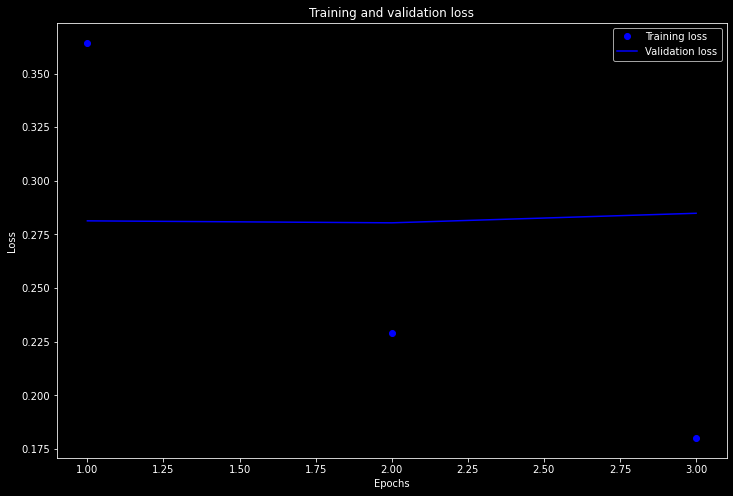

In [12]:
history_dict = fit_model.history
history_dict.keys()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.style.use('dark_background')
matplotlib.rcParams['figure.figsize']=[12.0,8.0]

plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

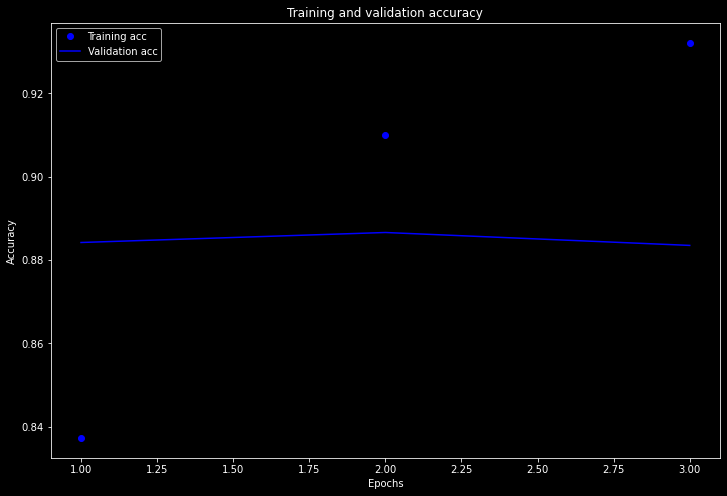

In [13]:
#plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [9]:
movie = input("Enter your movie name: ")
movie_hashtag='#'+movie.replace('/n','').replace(' ','')
print("Looking For Tweets: ", movie_hashtag)

KeyboardInterrupt: Interrupted by user

In [ ]:
#Getting Twitter Feed:
import tweepy
import config

client=tweepy.Client(bearer_token=config.BEARER_TOKEN)
query='review '+movie_hashtag+' -is:retweet lang:en -has:media'
response=client.search_recent_tweets(query=query, max_results=10)
#print(response)


In [ ]:
lst_movie_reviews_from_twtr=[]
for tweet in response.data:
    lst_movie_reviews_from_twtr.append(tweet.text)

In [ ]:
len(lst_movie_reviews_from_twtr)

In [ ]:
from tensorflow import keras
reconstructed_model = keras.models.load_model("sentiment-score-model")


#ex_text_str = "Another cash cow from Marvel. Never mind with a quality script. Let's just pump this crap out as fast as possible to cash in on the fame of Marvel. It's sick to know that Stan Lee sold out. This movie deserves negative stars. It sucks that bad."

data_test = {'review':lst_movie_reviews_from_twtr}
df_test = pd.DataFrame(data=data_test)
df_test.head()
df_test["review"]=df_test.review.apply(lambda x: clean_text(x))

list_sentences_test = df_test["review"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
prediction = reconstructed_model.predict(X_te)
print("prediction:",prediction)

In [ ]:
df_test['Sentiment Score']=prediction
df_test

In [ ]:
p_mean=prediction.mean()
if p_mean>=0.6:
    print('Must Watch','Average Review Score:',p_mean*100,'%')
if p_mean>0.3 and p_mean<0.6:
    print('Maybe Watch','Average Review Score:',p_mean*100,'%')
if p_mean<=0.3:
    print('Not Worth It','Average Review Score:',p_mean*100,'%')